In [1]:

import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor


from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error # for random forest

import matplotlib.pyplot as plt


# Load the dataset
file_path = 'hotel_booking.csv'
Raw_hotel_data = pd.read_csv(file_path)

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

# Display the first few rows of the dataset
Raw_hotel_data.head()



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [2]:
# List of unnecessary columns to drop
columns_to_drop = ['is_canceled', 'babies', 'lead_time','previous_cancellations', 'previous_bookings_not_canceled', 'required_car_parking_spaces', 'total_of_special_requests', 'name', 'email', 'phone-number', 'credit_card']

# Check if all columns exist in the DataFrame to avoid KeyErrors
missing_columns = [col for col in columns_to_drop if col not in Raw_hotel_data.columns]
if missing_columns:
    print(f"Warning: The following columns are not in the DataFrame and will not be dropped: {missing_columns}")

# Drop multiple columns and assign the result to a new DataFrame (to avoid using inplace)
Cleaned_hotel_data = Raw_hotel_data.drop(columns=columns_to_drop, errors='ignore')

# to use inplace modification
# Raw_hotel_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')



In [3]:
# Filter the DataFrame to keep only rows where 'reservation_status' is 'Check-Out'
hotel_data = Cleaned_hotel_data[Cleaned_hotel_data['reservation_status'] == 'Check-Out'].copy()



In [4]:
# Count unique values in each column
unique_counts = hotel_data.nunique()
print("Count of unique values in each column:")
print(unique_counts)



Count of unique values in each column:
hotel                           2
arrival_date_year               3
arrival_date_month             12
arrival_date_week_number       53
arrival_date_day_of_month      31
stays_in_weekend_nights        17
stays_in_week_nights           33
adults                          5
children                        4
meal                            5
country                       165
market_segment                  7
distribution_channel            5
is_repeated_guest               2
reserved_room_type              9
assigned_room_type             10
booking_changes                21
deposit_type                    3
agent                         314
company                       331
days_in_waiting_list           98
customer_type                   4
adr                          7610
reservation_status              1
reservation_status_date       805
dtype: int64


In [5]:
# Get unique values in a specific column
unique_values = hotel_data['reservation_status'].unique()
print(unique_values)



['Check-Out']


In [6]:
# Find missing values and their percentage
def print_missing_values(data):
    # Calculate the number of missing values per column
    missing_values = data.isnull().sum()

    # Calculate the percentage of missing values per column
    missing_percentage = (missing_values / len(data)) * 100

    # Combine results into a DataFrame
    missing_data = pd.DataFrame({
        'Missing Values': missing_values,
        '% of Total Values': missing_percentage
    })

    # Filter the DataFrame to only include columns with missing values
    missing_data_filtered = missing_data[missing_data['Missing Values'] > 0]

    # Check if there are any missing values to display
    if not missing_data_filtered.empty:
        print("\nMissing values in each column (only columns with missing values shown):")
        print(missing_data_filtered)
    else:
        print("No missing values found in the DataFrame.")



In [7]:
# print Missing values in each column
print_missing_values(hotel_data)




Missing values in each column (only columns with missing values shown):
         Missing Values  % of Total Values
country             421           0.560094
agent             12310          16.377085
company           69560          92.541841


In [8]:
# Handle missing values
hotel_data.fillna(method='ffill', inplace=True)



In [9]:
# print Missing values in each column
print_missing_values(hotel_data)




Missing values in each column (only columns with missing values shown):
         Missing Values  % of Total Values
agent                 3           0.003991
company              15           0.019956


In [10]:
# Drop rows with missing values
hotel_data = hotel_data.dropna()



In [11]:
# print Missing values in each column
print_missing_values(hotel_data)



No missing values found in the DataFrame.


In [12]:
# Check detail of each column
print("\nDetailed information about the dataset:")
print(hotel_data.info())




Detailed information about the dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75151 entries, 18 to 119389
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hotel                      75151 non-null  object 
 1   arrival_date_year          75151 non-null  int64  
 2   arrival_date_month         75151 non-null  object 
 3   arrival_date_week_number   75151 non-null  int64  
 4   arrival_date_day_of_month  75151 non-null  int64  
 5   stays_in_weekend_nights    75151 non-null  int64  
 6   stays_in_week_nights       75151 non-null  int64  
 7   adults                     75151 non-null  int64  
 8   children                   75151 non-null  float64
 9   meal                       75151 non-null  object 
 10  country                    75151 non-null  object 
 11  market_segment             75151 non-null  object 
 12  distribution_channel       75151 non-null  object 
 13  is_

In [13]:
# Add a serial number column
hotel_data['booking_id'] = range(1, len(hotel_data) + 1)

In [14]:
# Map month to numeric
month_dict = {'January' : 1,
             'February' : 2,
             'March' : 3,
             'April' : 4,
             'May' : 5,
             'June' : 6,
             'July' : 7,
             'August' : 8,
             'September' : 9,
             'October' : 10,
             'November' : 11,
             'December' : 12}
# Convert month to numeric
# hotel_data['arrival_date_month'] = hotel_data['arrival_date_month'].apply(lambda x: month_dict[x])
hotel_data['arrival_date_month'] = hotel_data['arrival_date_month'].map(month_dict)



In [15]:
# Combine the columns into a single datetime column
hotel_data['arrival_date'] = pd.to_datetime(hotel_data.rename(columns={
    'arrival_date_year': 'year', 
    'arrival_date_month': 'month', 
    'arrival_date_day_of_month': 'day'})[['year', 'month', 'day']])



In [16]:
# Convert the 'reservation_status_date' column to datetime
hotel_data['departure_date'] = pd.to_datetime(hotel_data['reservation_status_date'])



In [17]:
# Convert children column to int64
# hotel_data['children'] = np.int64(hotel_data['children'])
hotel_data['children'].fillna(0, inplace=True)  # Assuming it's sensible to assume 0 children if missing
hotel_data['children'] = hotel_data['children'].astype(int)


In [18]:
# Calculate room nights
hotel_data['room_nights'] = (hotel_data['departure_date'] - hotel_data['arrival_date']).dt.days

# Calculate revenue
hotel_data['revenue'] = hotel_data['room_nights'] * hotel_data['adr']

# Calculate Guest night adult
hotel_data['adult_nights'] = hotel_data['room_nights'] * hotel_data['adults']

# Calculate Guest night children
hotel_data['children_nights'] = hotel_data['room_nights'] * hotel_data['children']


In [19]:
# Extract year and month into a new column
hotel_data['year_month'] = hotel_data['arrival_date'].dt.to_period('M')




In [20]:
# Removing rows where 'room_nights' is 0
hotel_data = hotel_data[hotel_data['room_nights'] != 0]



In [21]:
# Removing rows where 'adr' is 0
hotel_data = hotel_data[hotel_data['adr'] != 0]



In [22]:
# Display the first 10 rows of the dataset again to ensure the print statements do not affect the output
print("\nDisplaying the first 10 rows again for verification:")
hotel_data.head(10)




Displaying the first 10 rows again for verification:


,hotel,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,reservation_status,reservation_status_date,booking_id,arrival_date,departure_date,room_nights,revenue,adult_nights,children_nights,year_month
18,Resort Hotel,2015,7,27,1,0,1,2,0,BB,FRA,Corporate,Corporate,0,A,G,0,No Deposit,240.0,110.0,0,Transient,107.42,Check-Out,2015-07-02,1,2015-07-01,2015-07-02,1,107.42,2,0,2015-07
19,Resort Hotel,2015,7,27,1,0,4,2,0,BB,GBR,Direct,Direct,0,G,G,0,No Deposit,250.0,110.0,0,Transient,153.00,Check-Out,2015-07-05,2,2015-07-01,2015-07-05,4,612.00,8,0,2015-07
20,Resort Hotel,2015,7,27,1,1,4,1,0,BB,GBR,Online TA,TA/TO,0,F,F,0,No Deposit,241.0,110.0,0,Transient,97.29,Check-Out,2015-07-06,3,2015-07-01,2015-07-06,5,486.45,5,0,2015-07
21,Resort Hotel,2015,7,27,1,2,4,2,0,BB,PRT,Direct,Direct,0,A,A,1,No Deposit,250.0,110.0,0,Transient,84.67,Check-Out,2015-07-07,4,2015-07-01,2015-07-07,6,508.02,12,0,2015-07
22,Resort Hotel,2015,7,27,1,2,4,2,0,BB,PRT,Direct,Direct,0,A,A,1,No Deposit,250.0,110.0,0,Transient,84.67,Check-Out,2015-07-07,5,2015-07-01,2015-07-07,6,508.02,12,0,2015-07
23,Resort Hotel,2015,7,27,1,2,4,2,0,BB,PRT,Direct,Direct,0,D,D,1,No Deposit,250.0,110.0,0,Transient,99.67,Check-Out,2015-07-07,6,2015-07-01,2015-07-07,6,598.02,12,0,2015-07
25,Resort Hotel,2015,7,27,1,2,5,2,0,BB,PRT,Offline TA/TO,TA/TO,0,D,D,0,No Deposit,5.0,110.0,0,Transient,63.60,Check-Out,2015-07-08,8,2015-07-01,2015-07-08,7,445.20,14,0,2015-07
26,Resort Hotel,2015,7,27,1,2,5,2,0,BB,IRL,Offline TA/TO,TA/TO,0,D,D,0,No Deposit,8.0,110.0,0,Contract,79.50,Check-Out,2015-07-08,9,2015-07-01,2015-07-08,7,556.50,14,0,2015-07
28,Resort Hotel,2015,7,27,1,2,5,2,0,BB,PRT,Online TA,TA/TO,0,A,A,0,No Deposit,240.0,110.0,0,Transient,94.00,Check-Out,2015-07-08,10,2015-07-01,2015-07-08,7,658.00,14,0,2015-07
29,Resort Hotel,2015,7,27,1,2,5,2,0,BB,PRT,Online TA,TA/TO,0,D,D,0,No Deposit,240.0,110.0,0,Transient,87.30,Check-Out,2015-07-08,11,2015-07-01,2015-07-08,7,611.10,14,0,2015-07


In [23]:
# Check detail of each column
print("\nDetailed information about the dataset again for verification:")
print(hotel_data.info())




Detailed information about the dataset again for verification:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73384 entries, 18 to 119389
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   hotel                      73384 non-null  object        
 1   arrival_date_year          73384 non-null  int64         
 2   arrival_date_month         73384 non-null  int64         
 3   arrival_date_week_number   73384 non-null  int64         
 4   arrival_date_day_of_month  73384 non-null  int64         
 5   stays_in_weekend_nights    73384 non-null  int64         
 6   stays_in_week_nights       73384 non-null  int64         
 7   adults                     73384 non-null  int64         
 8   children                   73384 non-null  int32         
 9   meal                       73384 non-null  object        
 10  country                    73384 non-null  object        
 11  m

In [24]:
print(hotel_data['arrival_date'].dtype)




datetime64[ns]


In [25]:
print(hotel_data.columns)


Index(['hotel', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'reserved_room_type', 'assigned_room_type',
       'booking_changes', 'deposit_type', 'agent', 'company',
       'days_in_waiting_list', 'customer_type', 'adr', 'reservation_status',
       'reservation_status_date', 'booking_id', 'arrival_date',
       'departure_date', 'room_nights', 'revenue', 'adult_nights',
       'children_nights', 'year_month'],
      dtype='object')


In [26]:
# Set the arrival_date column as the index
# hotel_data_time = hotel_data[['arrival_date','room_nights', 'adr', 'revenue']]
# hotel_data.set_index('year_month',inplace=True)
hotel_data.set_index('arrival_date',inplace=True)



In [27]:
#Export DataFrame to CSV
hotel_data.to_csv('hotel_data_beforegrouping.csv', index=False, encoding='utf-8')

In [28]:

# Aggregate data at monthly level
hotel_data_monthly = hotel_data.groupby(['year_month', 'hotel', 'country', 'meal', 'market_segment', 'reserved_room_type']).agg({
    'booking_id': 'count',
    'adult_nights': 'sum',
    'children_nights': 'sum',
    'stays_in_weekend_nights': 'sum',
    'stays_in_week_nights': 'sum',
    'room_nights': 'sum',
    'revenue': 'sum'
}).reset_index()

# Calculate the ADR
hotel_data_monthly['adr'] = hotel_data_monthly['revenue'] / hotel_data_monthly['room_nights']

# Average stay
hotel_data_monthly['average_stay'] = hotel_data_monthly['room_nights'] / hotel_data_monthly['booking_id']

(hotel_data_monthly.head())



,year_month,hotel,country,meal,market_segment,reserved_room_type,booking_id,adult_nights,children_nights,stays_in_weekend_nights,stays_in_week_nights,room_nights,revenue,adr,average_stay
0,2015-07,City Hotel,BRA,BB,Groups,A,8,15,0,0,8,8,477.00,59.625000,1.000000
1,2015-07,City Hotel,BRA,BB,Online TA,A,1,6,0,0,3,3,176.70,58.900000,3.000000
2,2015-07,City Hotel,DEU,BB,Offline TA/TO,A,3,41,0,5,12,17,1462.60,86.035294,5.666667
3,2015-07,City Hotel,DEU,BB,Online TA,A,1,4,0,0,2,2,111.92,55.960000,2.000000
4,2015-07,City Hotel,DEU,BB,Online TA,B,2,6,0,1,4,5,348.50,69.700000,2.500000


In [29]:
#Export DataFrame to CSV
hotel_data_monthly.to_csv('hotel_data_monthly_beforeencoding.csv', index=False, encoding='utf-8')

In [30]:
# Encode categorical variables
categorical_features = ['hotel', 'country', 'meal', 'market_segment', 'reserved_room_type']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(hotel_data_monthly[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))



In [31]:
# Combine encoded features with monthly data
hotel_data_encoded = pd.concat([hotel_data_monthly.drop(columns=categorical_features), encoded_df], axis=1)



In [32]:
print(hotel_data_encoded.columns)



Index(['year_month', 'booking_id', 'adult_nights', 'children_nights',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'room_nights',
       'revenue', 'adr', 'average_stay',
       ...
       'market_segment_Online TA', 'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L'],
      dtype='object', length=198)


In [33]:
hotel_data_encoded.head(100)



,year_month,booking_id,adult_nights,children_nights,stays_in_weekend_nights,stays_in_week_nights,room_nights,revenue,adr,average_stay,hotel_City Hotel,hotel_Resort Hotel,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GHA,country_GIB,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HRV,country_HUN,country_IDN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JOR,country_JPN,country_KAZ,country_KEN,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_NAM,country_NCL,country_NGA,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VNM,country_ZAF,country_ZMB,country_ZWE,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L
0,2015-07,8,15,0,0,8,8,477.00,59.625000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-07,1,6,0,0,3,3,176.70,58.900000,3.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [34]:
#Export DataFrame to CSV
hotel_data_encoded.to_csv('hotel_data_bookinmodeldata.csv', index=False, encoding='utf-8')

# Random Forest regressor - Model for predicting ADR and Room nights

In [35]:
# Check detail of each column
print("\nDetailed information about the dataset:")
print(hotel_data_encoded.info())

# Create a new DataFrame from the dtypes of the original DataFrame
data_types_hotel_data_encoded = pd.DataFrame(hotel_data_encoded.dtypes, columns=['Data Type'])

# Reset index to get column names as a separate column
data_types_hotel_data_encoded.reset_index(inplace=True)
data_types_hotel_data_encoded.rename(columns={'index': 'Column Name'}, inplace=True)

# Display the DataFrame
print(data_types_hotel_data_encoded)




Detailed information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13205 entries, 0 to 13204
Columns: 198 entries, year_month to reserved_room_type_L
dtypes: float64(191), int64(6), period[M](1)
memory usage: 19.9 MB
None
                      Column Name  Data Type
0                      year_month  period[M]
1                      booking_id      int64
2                    adult_nights      int64
3                 children_nights      int64
4         stays_in_weekend_nights      int64
5            stays_in_week_nights      int64
6                     room_nights      int64
7                         revenue    float64
8                             adr    float64
9                    average_stay    float64
10               hotel_City Hotel    float64
11             hotel_Resort Hotel    float64
12                    country_ABW    float64
13                    country_AGO    float64
14                    country_AIA    float64
15                    country_ALB 

In [36]:
# Drop rows with NaN values generated by lag features
hotel_data_encoded.dropna(inplace=True)



In [37]:
# Define features and target for ADR
X_adr = hotel_data_encoded.drop(['year_month', 'booking_id', 'revenue', 'adr', 'room_nights'], axis=1)  # Exclude non-features and other targets
y_adr = hotel_data_encoded['adr']

# Train-test split for ADR - chronological split
train_size_adr = int(0.8 * len(X_adr))
X_train_adr, X_test_adr = X_adr[:train_size_adr], X_adr[train_size_adr:]
y_train_adr, y_test_adr = y_adr[:train_size_adr], y_adr[train_size_adr:]



In [38]:
# Initialize RandomForest and set up GridSearchCV with TimeSeriesSplit for ADR
model_adr = RandomForestRegressor(random_state=42)
param_grid_adr = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4]
}
tscv_adr = TimeSeriesSplit(n_splits=5)  # Time series cross-validation
grid_search_adr = GridSearchCV(estimator=model_adr, param_grid=param_grid_adr, cv=tscv_adr, scoring='neg_mean_squared_error')
grid_search_adr.fit(X_train_adr, y_train_adr)

# Best model for ADR
best_model_adr = grid_search_adr.best_estimator_
adr_predictions = best_model_adr.predict(X_test_adr)
mse_adr = mean_squared_error(y_test_adr, adr_predictions)
print("Best parameters for ADR:", grid_search_adr.best_params_)
print("Mean Squared Error for ADR:", mse_adr)



Best parameters for ADR: {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 200}
Mean Squared Error for ADR: 3339.517965859164


In [39]:
# Repeat similar steps for Room Nights
X_room_nights = hotel_data_encoded.drop(['year_month', 'booking_id', 'revenue', 'adr', 'room_nights'], axis=1)
y_room_nights = hotel_data_encoded['room_nights']

train_size_rn = int(0.8 * len(X_room_nights))
X_train_rn, X_test_rn = X_room_nights[:train_size_rn], X_room_nights[train_size_rn:]
y_train_rn, y_test_rn = y_room_nights[:train_size_rn], y_room_nights[train_size_rn:]



In [40]:
model_rn = RandomForestRegressor(random_state=42)
param_grid_rn = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4]
}
tscv_rn = TimeSeriesSplit(n_splits=5)
grid_search_rn = GridSearchCV(estimator=model_rn, param_grid=param_grid_rn, cv=tscv_rn, scoring='neg_mean_squared_error')
grid_search_rn.fit(X_train_rn, y_train_rn)

best_model_rn = grid_search_rn.best_estimator_
room_nights_predictions = best_model_rn.predict(X_test_rn)
mse_room_nights = mean_squared_error(y_test_rn, room_nights_predictions)
print("Best parameters for Room Nights:", grid_search_rn.best_params_)
print("Mean Squared Error for Room Nights:", mse_room_nights)

Best parameters for Room Nights: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error for Room Nights: 2.886159598217039


# Comparrison of predictions with the actual values

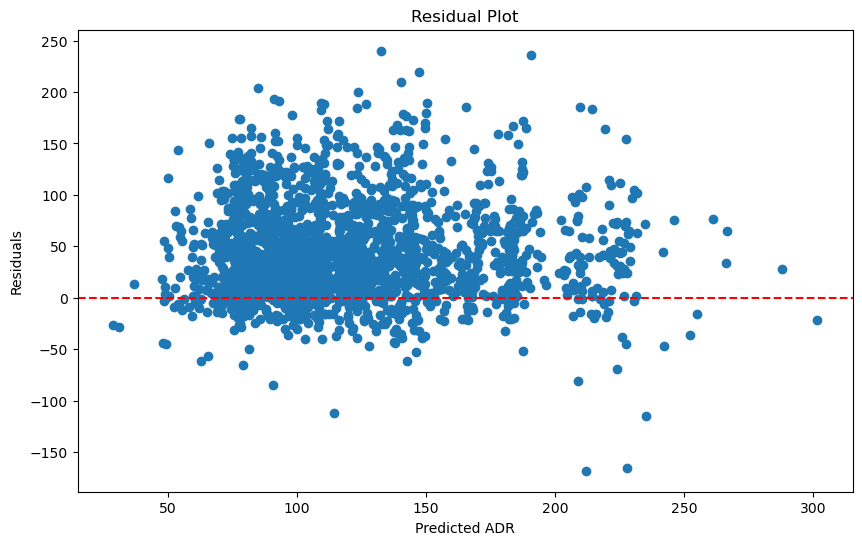

Mean of the Residuals: 39.07946987148763


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions were stored in 'adr_predictions'
# Actual values are in 'y_test_adr'
residuals_adr = y_test_adr - adr_predictions

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(adr_predictions, residuals_adr)
plt.title('Residual Plot')
plt.xlabel('Predicted ADR')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Checking for mean of residuals
mean_residuals = np.mean(residuals_adr)
print("Mean of the Residuals:", mean_residuals)



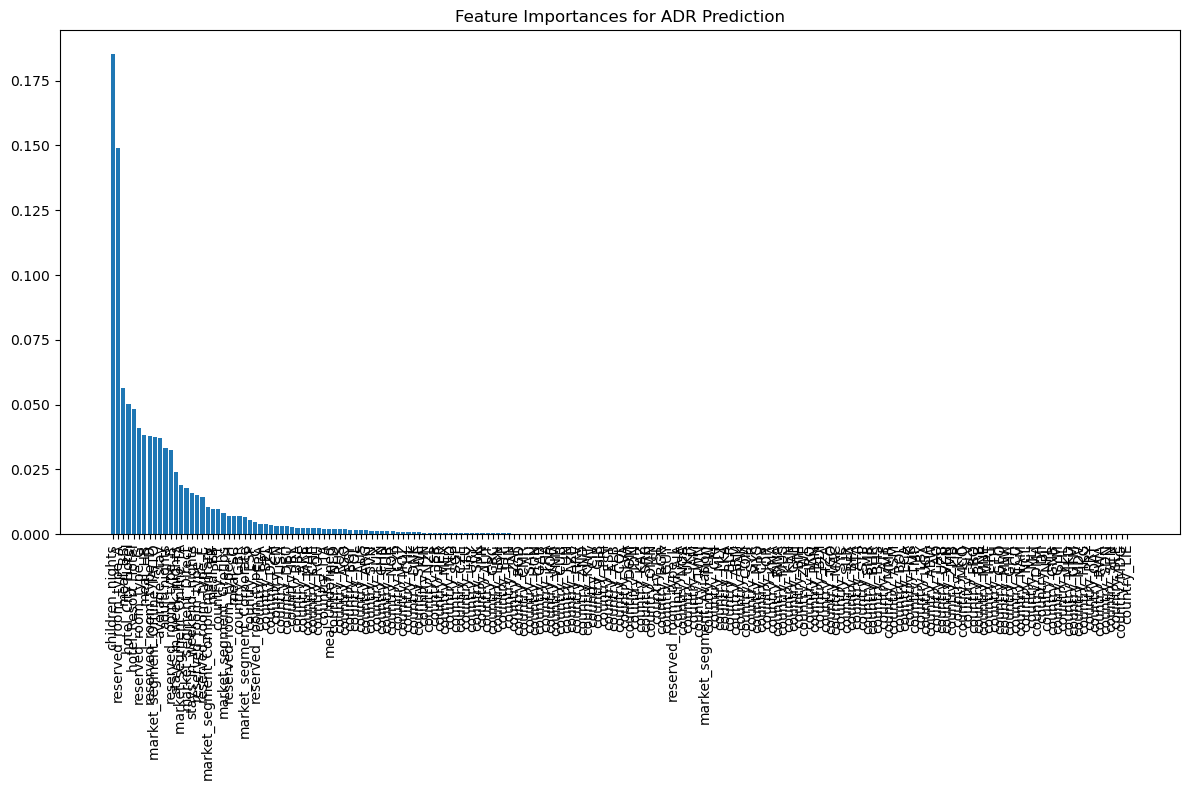

In [44]:
# Using the Random Forest model 'best_model_adr' from GridSearchCV
feature_importances_adr = best_model_adr.feature_importances_
features = X_train_adr.columns

# Sorting the features by importance
sorted_indices = np.argsort(feature_importances_adr)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances for ADR Prediction')
plt.bar(range(len(sorted_indices)), feature_importances_adr[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), features[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


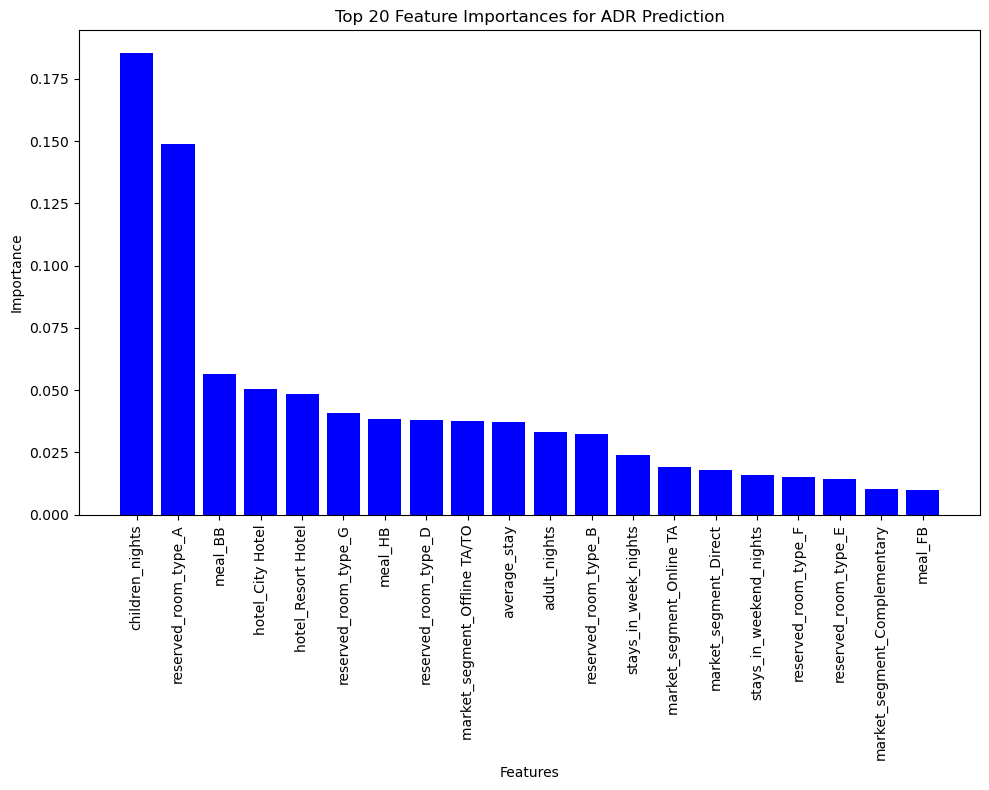

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Using the Random Forest model 'best_model_adr' from GridSearchCV
feature_importances_adr = best_model_adr.feature_importances_
features = X_train_adr.columns

# Define the number of top features you want to display
N = 20  # You can adjust this number based on how many top features you want to display

# Sorting the features by importance and getting the top N
sorted_indices = np.argsort(feature_importances_adr)[-N:][::-1]

plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances for ADR Prediction')
plt.bar(range(N), feature_importances_adr[sorted_indices], color='blue', align='center')
plt.xticks(range(N), np.array(features)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


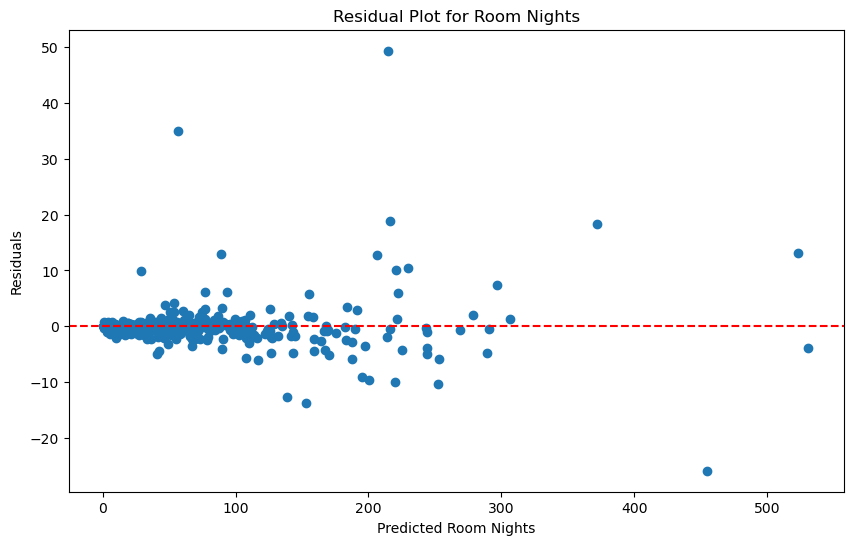

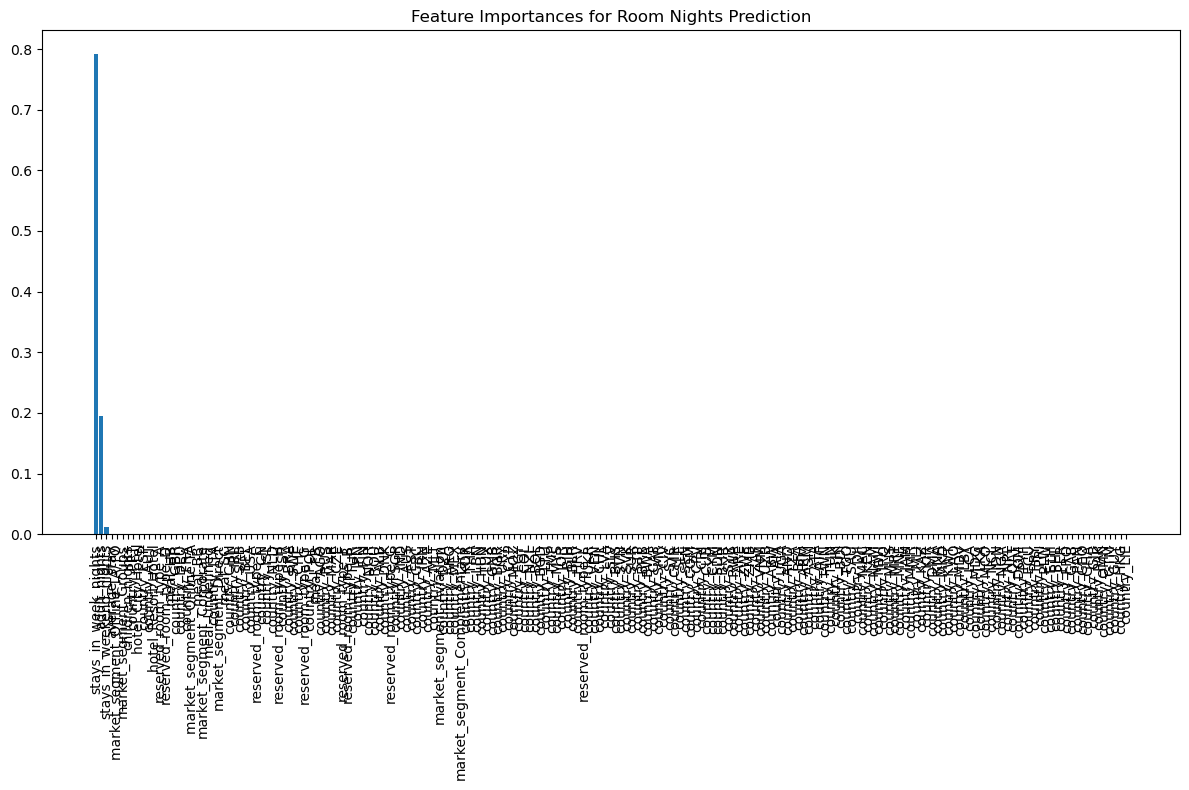

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals_room_nights = y_test_rn - room_nights_predictions

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(room_nights_predictions, residuals_room_nights)
plt.title('Residual Plot for Room Nights')
plt.xlabel('Predicted Room Nights')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Feature Importance
feature_importances_rn = best_model_rn.feature_importances_
features_rn = X_train_rn.columns
sorted_indices_rn = np.argsort(feature_importances_rn)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances for Room Nights Prediction')
plt.bar(range(len(sorted_indices_rn)), feature_importances_rn[sorted_indices_rn], align='center')
plt.xticks(range(len(sorted_indices_rn)), features_rn[sorted_indices_rn], rotation=90)
plt.tight_layout()
plt.show()



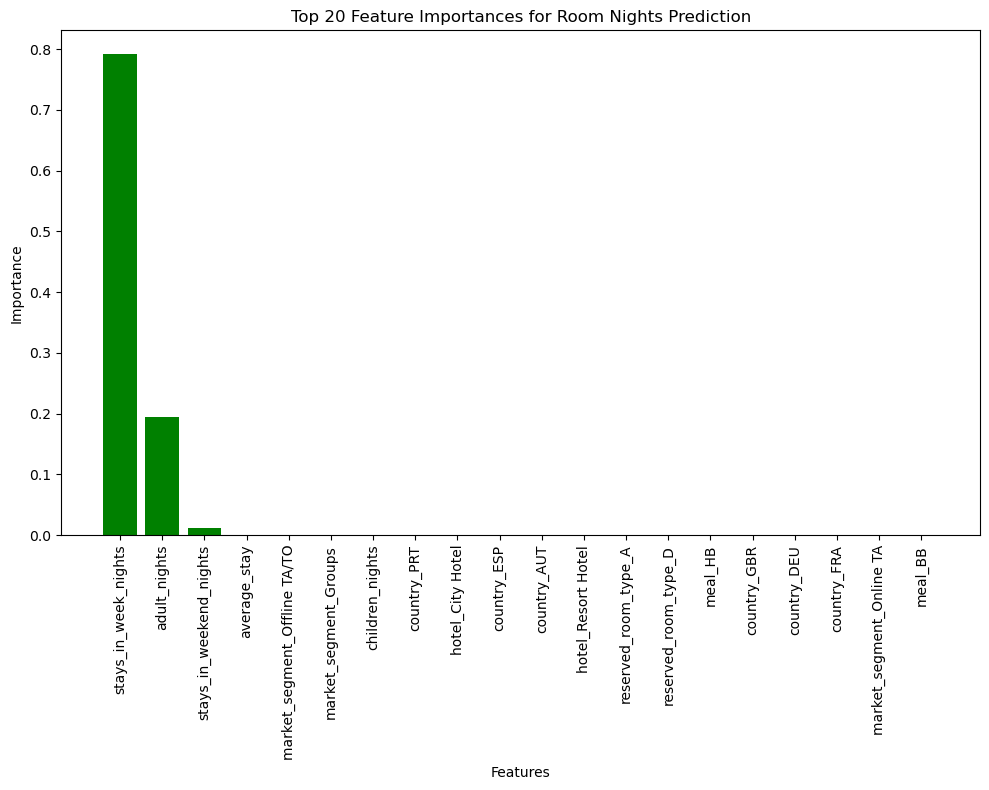

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Feature Importances from the Random Forest model 'best_model_rn'
feature_importances_rn = best_model_rn.feature_importances_
features_rn = X_train_rn.columns

# Define the number of top features you want to display
N = 20  # Adjust the number to display as many top features as needed

# Sorting the features by importance and getting the top N
sorted_indices_rn = np.argsort(feature_importances_rn)[-N:][::-1]

plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances for Room Nights Prediction')
plt.bar(range(N), feature_importances_rn[sorted_indices_rn], color='green', align='center')
plt.xticks(range(N), np.array(features_rn)[sorted_indices_rn], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


In [49]:
# Assuming 'best_model_adr' and 'best_model_rn' are your trained models for ADR and room nights respectively
adr_predictions_train = best_model_adr.predict(X_train_adr)
adr_predictions_test = best_model_adr.predict(X_test_adr)

room_nights_predictions_train = best_model_rn.predict(X_train_rn)
room_nights_predictions_test = best_model_rn.predict(X_test_rn)


In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert indices to Series (assuming they represent dates or are suitable as date identifiers)
train_dates_series = pd.Series(train_dates, index=train_dates)
test_dates_series = pd.Series(test_dates, index=test_dates)

# Create DataFrames for actuals and predictions
adr_data = pd.DataFrame({
    'Date': pd.concat([train_dates_series, test_dates_series]),
    'Actual ADR': pd.concat([y_train_adr, y_test_adr]),
    'Predicted ADR': pd.concat([pd.Series(adr_predictions_train, index=train_dates),
                                pd.Series(adr_predictions_test, index=test_dates)])
})

room_nights_data = pd.DataFrame({
    'Date': pd.concat([train_dates_series, test_dates_series]),
    'Actual Room Nights': pd.concat([y_train_rn, y_test_rn]),
    'Predicted Room Nights': pd.concat([pd.Series(room_nights_predictions_train, index=train_dates),
                                        pd.Series(room_nights_predictions_test, index=test_dates)])
})

# Plotting
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(adr_data['Date'], adr_data['Actual ADR'], label='Actual ADR', color='blue')
plt.plot(adr_data['Date'], adr_data['Predicted ADR'], label='Predicted ADR', color='red')
plt.title('Actual vs Predicted ADR')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(room_nights_data['Date'], room_nights_data['Actual Room Nights'], label='Actual Room Nights', color='green')
plt.plot(room_nights_data['Date'], room_nights_data['Predicted Room Nights'], label='Predicted Room Nights', color='orange')
plt.title('Actual vs Predicted Room Nights')
plt.xlabel('Date')
plt.ylabel('Room Nights')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'train_dates' is not defined